In [2]:
# %matplotlib widget


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# setup latex style for plots exported to svg
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


# Anti-backlash test data

In [3]:
def average_test_repetitions(df, groupby):
    data = []
    grouped = df.groupby(groupby)

    for name, group in grouped:
        group = group.drop(groupby, axis=1)
        group.index = group.index - group.index[0]

        old_len = len(group)
        group = group.resample('0.5ms').mean()
        group = group.interpolate(method='time')
        # print(f'test {name} resampled from {old_len} to {len(group)} samples')

        data.append(group.values)

    # get consistent length
    min_len = min([len(d) for d in data])
    data = [d[:min_len] for d in data]
    # print(f'setting everything to {min_len} samples')

    # average data using numpy
    data_mean = np.mean(np.array(data), axis=0)

    new_columns = df.columns.drop(groupby)
    mean_df = pd.DataFrame(data_mean, columns=new_columns)

    time_index = pd.timedelta_range(start=0, periods=min_len, freq='0.5ms')
    mean_df.index = time_index

    # smooth data
    mean_df = mean_df.rolling(window=100, center=True).mean()
    mean_df = mean_df.bfill().ffill()

    return mean_df


class actuator_test_data:
    def __init__(self, configuration='...'):
        self.configuration = configuration
        self.raw_torque_ramps = {}
        self.torque_ramps = {}
        self.speed_ramps = {}
        self.runin_tests = []

        
    def add_test_moment(self, phase, files):
        torque_ramp_files = [f for f in files if 'torqueramp' in f]
        speed_ramp_files = [f for f in files if 'speedramp' in f]
        
        if torque_ramp_files:
            self.add_torque_ramps(phase, torque_ramp_files)
        
        for file in speed_ramp_files:
            self.add_speed_ramp(phase, file)

    def add_torque_ramps(self, name, files):
        torque_ramps = {}
        for i, filename in enumerate(files):
            df_raw = pd.read_csv(filename)
            # print(f'{filename} loaded\t {list(df_raw.columns)}')

            df = pd.DataFrame()
            df['Time [s]'] = df_raw['TIME']
            df['Motor Torque [Nm]'] = df_raw['TORQUE']
            df['Deflection [deg]'] = df_raw['POSITION'] * 360
            df['Desired Torque [Nm]'] = df_raw['CONTROL_TORQUE']
            df['Motor Q_current [A]'] = df_raw['Q_CURRENT']
            df['test_nr'] = df_raw['test_nr']

            # print(f'Sample rate: {1/(df["Time [s]"].diff().mean())} Hz')
            df['Time [s]'] = pd.to_timedelta(df['Time [s]'], unit='s')
            df.set_index('Time [s]', inplace=True)

            self.raw_torque_ramps[name] = df

            print(f"loaded {filename}.\t Test postion: {df['Deflection [deg]'].mean():5.2f} deg")
            df['Deflection [deg]'] -= df['Deflection [deg]'].mean()
            
            TEST_NR_OFFSET = 100
            play_tests = df[df['test_nr'] < TEST_NR_OFFSET].copy()
            stiffness_tests = df[df['test_nr'] >= TEST_NR_OFFSET].copy()
            stiffness_tests['test_nr'] = stiffness_tests['test_nr'] - TEST_NR_OFFSET

            play_test_mean = average_test_repetitions(play_tests, 'test_nr')
            stiffness_test_mean = average_test_repetitions(stiffness_tests, 'test_nr')

            # shift to around 0, subtract mean
            play_test_mean['Deflection [deg]'] -= play_test_mean['Deflection [deg]'].mean()
            stiffness_test_mean['Deflection [deg]'] -= stiffness_test_mean['Deflection [deg]'].mean()

            torque_ramps[i] = (play_test_mean, stiffness_test_mean)

        test_pos = 0
        combined_play = None
        combined_stiffness = None
        for i, (play_test, stiffness_test) in torque_ramps.items():
            play_test['test_pos'] = test_pos
            stiffness_test['test_pos'] = test_pos
            test_pos += 1

            if combined_play is None:
                combined_play = play_test
                combined_stiffness = stiffness_test
            else:
                combined_play = pd.concat([combined_play, play_test])
                combined_stiffness = pd.concat([combined_stiffness, stiffness_test])

        combined_play = average_test_repetitions(combined_play, 'test_pos')
        combined_stiffness = average_test_repetitions(combined_stiffness, 'test_pos')
        combined_play['Deflection [deg]'] -= combined_play['Deflection [deg]'].mean()
        combined_stiffness['Deflection [deg]'] -= combined_stiffness['Deflection [deg]'].mean()
        torque_ramps['combined'] = (combined_play, combined_stiffness)    

        self.torque_ramps[name] = torque_ramps

    def add_speed_ramp(self, name, filename):
        df_raw = pd.read_csv(filename)

        df = pd.DataFrame()
        df['Motor Speed [rpm]'] = df_raw['VELOCITY']
        df['Motor Torque [Nm]'] = df_raw['TORQUE']
        df['Averaged Torque [Nm]'] = df['Motor Torque [Nm]'].rolling(window=500, center=True).mean()
        df['Motor Q_current [A]'] = df_raw['Q_CURRENT']

        df['Time [s]'] = pd.to_timedelta(df_raw['TIME'], unit='s')
        df.set_index('Time [s]', inplace=True)  
        
        print(f'loaded {filename}.')
        self.speed_ramps[name] = df

    def add_runin_tests(self, files):
        def read_file(filename):
            df_raw = pd.read_csv(filename, sep=';')
            
            if 'DIRECTION' not in df_raw.columns:
                # df_raw['TIME'] /= 1e9
                df_raw['DIRECTION'] = 1
            df = pd.DataFrame()
            df['Motor Torque [Nm]'] = df_raw['TORQUE']  # * df_raw['DIRECTION']
            df['Averaged Torque [Nm]'] = df['Motor Torque [Nm]'].rolling(window=100, center=True).mean()
            df['Motor Temperature [c]'] = df_raw['MOTOR_TEMPERATURE'] *0.442 - 1.62   #approximation to compensate incorrect NTC
            df['Controller Temperature'] = df_raw['TEMPERATURE']
            
            df_raw['TIME'] = (df_raw['TIME'] - df_raw['TIME'].iloc[0]) / 1e9
            df['Time [s]'] = pd.to_timedelta(df_raw['TIME'], unit='s')
            df.set_index('Time [s]', inplace=True)
            
            return df

        df = read_file(files[0])
        df['test number'] = 0
        for filename in files[1:]:
            df2 = read_file(filename)
            df2.index = df2.index + df.index[-1] + pd.Timedelta(1, unit='ms')
            df2['test number'] = df['test number'].iloc[-1] + 1
            df = pd.concat([df, df2])

        print(f'loaded {len(files)} run-in tests, measured time: {df.index[-1]}')

        self.runin_tests = df

    def describe(self):
        print(f'Configuration: {self.configuration}')
        print(f'Speed ramps: {list(self.speed_ramps.keys())}')
        print(f'Torque ramps:')
        for name, ramps in self.torque_ramps.items():
            print(f'  {name}: {len(ramps)} ramps ({ramps.keys()})')
        print(f'Run-in tests: {self.runin_tests["test number"].max()+1} tests, total time: {self.runin_tests.index[-1]}')

In [4]:
tests_split_pccf_u = actuator_test_data('Split Pinwheel undersized (PC-CF)')
tests_split_pccf_u.add_test_moment('initial', [
    'test_data/2024-07-10__12-06-49_speedramp_split init_120s.csv',
    # 'test_data/2024-07-10__12-30-32__torqueramp__split init1.csv',
    'test_data/2024-07-10__12-34-04__torqueramp__split init1.csv',
    'test_data/2024-07-10__12-39-58__torqueramp__split init5.csv',
    'test_data/2024-07-10__12-45-53__torqueramp__split init6.csv', 
])
tests_split_pccf_u.add_runin_tests([
    'test_data/2024-07-10__15-56-23_run-in_split_0.35rps.csv',
])
tests_split_pccf_u.add_test_moment('after run-in', [
    'test_data/2024-07-10__16-10-16_speedramp_split 10min_120s.csv',
    'test_data/2024-07-10__16-27-11__torqueramp__split runin1.csv',
    'test_data/2024-07-10__16-31-56__torqueramp__split runin5.csv',
    'test_data/2024-07-10__16-35-37__torqueramp__split runin6.csv',
    # 'test_data/2024-07-10__16-39-51_speedramp_split runin_120s.csv',
])
tests_split_pccf_u.add_test_moment('preload increase 1', [
    'test_data/2024-07-10__16-44-11_speedramp_split 1pre_120s.csv',
    'test_data/2024-07-10__16-48-09__torqueramp__split 1pre1.csv',
    'test_data/2024-07-10__16-52-42__torqueramp__split 1pre5.csv',
    'test_data/2024-07-10__16-58-03__torqueramp__split 1pre6.csv',
])

    # 'test_data/2024-07-11__11-11-47_speedramp_split 2pre_120s.csv',
    # 'test_data/2024-07-11__11-17-34_speedramp_split 1.5pre_120s.csv',
tests_split_pccf_u.add_test_moment('preload increase 2', [
    'test_data/2024-07-11__11-26-10_speedramp_split 2pre_120s.csv',
    'test_data/2024-07-11__11-32-34__torqueramp__split 2pre1.csv',
    'test_data/2024-07-11__11-37-19__torqueramp__split 2pre5.csv',
    'test_data/2024-07-11__11-42-35__torqueramp__split 2pre6.csv',
])
tests_split_pccf_u.add_test_moment('preload increase 3', [
    'test_data/2024-07-11__12-18-00_speedramp_split 3pre_120s.csv',
    'test_data/2024-07-11__12-24-10__torqueramp__split 3pre1.csv',
    'test_data/2024-07-11__12-29-25__torqueramp__split 3pre5.csv',
    'test_data/2024-07-11__12-43-57__torqueramp__split 3pre6.csv',
])
tests_split_pccf_u.add_test_moment('preload increase 4', [
    'test_data/2024-07-11__13-20-23_speedramp_split 4pre_120s.csv',
    'test_data/2024-07-11__13-26-36__torqueramp__split 4pre1.csv',
    'test_data/2024-07-11__13-42-44__torqueramp__split 4pre5.csv',
    'test_data/2024-07-11__13-46-33__torqueramp__split 4pre6.csv',
])
tests_split_pccf_u.add_test_moment('preload increase 5', [
        'test_data/2024-07-11__13-51-30_speedramp_split 5pre_120s.csv',
])

print('\n')
tests_split_pccf_u.describe()

loaded test_data/2024-07-10__12-34-04__torqueramp__split init1.csv.	 Test postion: 11.16 deg
loaded test_data/2024-07-10__12-39-58__torqueramp__split init5.csv.	 Test postion: -2.97 deg
loaded test_data/2024-07-10__12-45-53__torqueramp__split init6.csv.	 Test postion:  7.38 deg
loaded test_data/2024-07-10__12-06-49_speedramp_split init_120s.csv.
loaded 1 run-in tests, measured time: 0 days 00:10:12.434426100
loaded test_data/2024-07-10__16-27-11__torqueramp__split runin1.csv.	 Test postion:  3.72 deg
loaded test_data/2024-07-10__16-31-56__torqueramp__split runin5.csv.	 Test postion: -9.84 deg
loaded test_data/2024-07-10__16-35-37__torqueramp__split runin6.csv.	 Test postion:  0.26 deg
loaded test_data/2024-07-10__16-10-16_speedramp_split 10min_120s.csv.
loaded test_data/2024-07-10__16-48-09__torqueramp__split 1pre1.csv.	 Test postion:  3.91 deg
loaded test_data/2024-07-10__16-52-42__torqueramp__split 1pre5.csv.	 Test postion: -8.87 deg
loaded test_data/2024-07-10__16-58-03__torqueramp_

In [5]:
tests_base_pccf = actuator_test_data('Baseline (PC-CF)')
tests_base_pccf.add_test_moment('initial', [
    'test_data/2024-07-11__14-38-26_speedramp_base init_120s.csv',
    # 'test_data/2024-07-11__14-44-21__torqueramp__base init1.csv',
    # 'test_data/2024-07-11__14-50-03__torqueramp__base init5.csv',         # locking plate not fixed correctly
    'test_data/2024-07-11__14-54-07__torqueramp__base init1.csv',
    'test_data/2024-07-11__14-59-51__torqueramp__base init5.csv',
    'test_data/2024-07-11__15-06-17__torqueramp__base init6.csv',
])
tests_base_pccf.add_runin_tests([
    'test_data/2024-07-11__15-12-31_run-in_base_0.35rps.csv',
])
tests_base_pccf.add_test_moment('after run-in', [
    'test_data/2024-07-11__15-26-00_speedramp_base runin_120s.csv',
    'test_data/2024-07-11__15-47-12__torqueramp__base runin1.csv',
    'test_data/2024-07-11__15-51-51__torqueramp__base runin5.csv',
    'test_data/2024-07-11__15-56-27__torqueramp__base runin6.csv',
])

print('\n')
tests_base_pccf.describe()

loaded test_data/2024-07-11__14-54-07__torqueramp__base init1.csv.	 Test postion:  1.37 deg
loaded test_data/2024-07-11__14-59-51__torqueramp__base init5.csv.	 Test postion: -11.85 deg
loaded test_data/2024-07-11__15-06-17__torqueramp__base init6.csv.	 Test postion: -1.79 deg
loaded test_data/2024-07-11__14-38-26_speedramp_base init_120s.csv.
loaded 1 run-in tests, measured time: 0 days 00:11:11.191207800
loaded test_data/2024-07-11__15-47-12__torqueramp__base runin1.csv.	 Test postion:  1.58 deg
loaded test_data/2024-07-11__15-51-51__torqueramp__base runin5.csv.	 Test postion: -12.11 deg
loaded test_data/2024-07-11__15-56-27__torqueramp__base runin6.csv.	 Test postion: -1.66 deg
loaded test_data/2024-07-11__15-26-00_speedramp_base runin_120s.csv.


Configuration: Baseline (PC-CF)
Speed ramps: ['initial', 'after run-in']
Torque ramps:
  initial: 4 ramps (dict_keys([0, 1, 2, 'combined']))
  after run-in: 4 ramps (dict_keys([0, 1, 2, 'combined']))
Run-in tests: 1 tests, total time: 0 day

In [6]:
tests_conic_pccf = actuator_test_data('Conic Disk (PC-CF)')
tests_conic_pccf.add_test_moment('initial', [
    'test_data/2024-07-12__11-25-30_speedramp_conic init_120s.csv',
    'test_data/2024-07-12__11-33-31__torqueramp__conic init1.csv', 
    'test_data/2024-07-12__12-23-01__torqueramp__conic init5.csv',
    'test_data/2024-07-12__12-29-20__torqueramp__conic init6.csv',
])
tests_conic_pccf.add_runin_tests([
    'test_data/2024-07-12__12-40-29_run-in_conic_0.35rps.csv',
    'test_data/2024-07-12__12-55-01_run-in_conic_0.35rps.csv',
])
tests_conic_pccf.add_test_moment('after run-in', [
    'test_data/2024-07-12__12-57-37_speedramp_conic runin_120s.csv',
    'test_data/2024-07-12__13-05-47__torqueramp__conic runin1.csv',
    'test_data/2024-07-12__13-16-01__torqueramp__conic runin5.csv',
    'test_data/2024-07-12__13-32-22__torqueramp__conic runin6.csv',
])
tests_conic_pccf.add_test_moment('preload increase 1', [
    'test_data/2024-07-12__13-58-40_speedramp_conic 1pre_120s.csv',
    'test_data/2024-07-12__14-07-48__torqueramp__conic 1pre1.csv',
    'test_data/2024-07-12__14-26-23__torqueramp__conic 1pre5.csv',
    'test_data/2024-07-12__14-31-48__torqueramp__conic 1pre6.csv',
])
tests_conic_pccf.add_test_moment('preload increase 2', [
    'test_data/2024-07-12__14-45-16_speedramp_conic 2pre_120s.csv',
    'test_data/2024-07-12__14-52-50__torqueramp__conic 2pre1.csv',
    'test_data/2024-07-12__14-57-29__torqueramp__conic 2pre5.csv',
    'test_data/2024-07-12__15-12-22__torqueramp__conic 2pre6.csv',
])
tests_conic_pccf.add_test_moment('preload increase 3', [
    'test_data/2024-07-12__16-18-48_speedramp_conic 3pre_120s.csv',
    'test_data/2024-07-12__16-23-23__torqueramp__conic 3pre1.csv',
    'test_data/2024-07-12__16-34-37__torqueramp__conic 3pre5.csv',
    'test_data/2024-07-12__16-28-44__torqueramp__conic 3pre6.csv',
])
tests_conic_pccf.add_test_moment('preload increase 4', [
    'test_data/2024-07-12__16-41-31_speedramp_conic 4pre_120s.csv',
    'test_data/2024-07-12__16-46-43__torqueramp__conic 4pre1.csv',
    'test_data/2024-07-12__16-57-04__torqueramp__conic 4pre5.csv',
    'test_data/2024-07-12__16-51-38__torqueramp__conic 4pre6.csv',
])
tests_conic_pccf.add_test_moment('preload increase 5', [
    'test_data/2024-07-12__17-03-46_speedramp_conic 5pre_120s.csv',
    'test_data/2024-07-12__17-09-01__torqueramp__conic 5pre1.csv',
    'test_data/2024-07-12__17-17-36__torqueramp__conic 5pre5.csv', 
    'test_data/2024-07-12__17-13-06__torqueramp__conic 5pre6.csv',
])

print('\n')
tests_conic_pccf.describe()

loaded test_data/2024-07-12__11-33-31__torqueramp__conic init1.csv.	 Test postion:  6.46 deg
loaded test_data/2024-07-12__12-23-01__torqueramp__conic init5.csv.	 Test postion: -8.41 deg
loaded test_data/2024-07-12__12-29-20__torqueramp__conic init6.csv.	 Test postion:  1.71 deg
loaded test_data/2024-07-12__11-25-30_speedramp_conic init_120s.csv.
loaded 2 run-in tests, measured time: 0 days 00:12:27.924977900
loaded test_data/2024-07-12__13-05-47__torqueramp__conic runin1.csv.	 Test postion:  5.06 deg
loaded test_data/2024-07-12__13-16-01__torqueramp__conic runin5.csv.	 Test postion: -7.95 deg
loaded test_data/2024-07-12__13-32-22__torqueramp__conic runin6.csv.	 Test postion:  2.47 deg
loaded test_data/2024-07-12__12-57-37_speedramp_conic runin_120s.csv.
loaded test_data/2024-07-12__14-07-48__torqueramp__conic 1pre1.csv.	 Test postion:  5.70 deg
loaded test_data/2024-07-12__14-26-23__torqueramp__conic 1pre5.csv.	 Test postion: -8.12 deg
loaded test_data/2024-07-12__14-31-48__torqueramp_

In [7]:
tests_split_pccf = actuator_test_data('Split Pinwheel (PC-CF)') 
tests_split_pccf.add_test_moment('initial', [
    'test_data/2024-07-15__14-09-03_speedramp_split init_120s.csv',
    'test_data/2024-07-15__14-17-32__torqueramp__split init1.csv',
    'test_data/2024-07-15__14-26-05__torqueramp__split init5.csv',
    'test_data/2024-07-15__14-35-07__torqueramp__split init6.csv',
])
tests_split_pccf.add_runin_tests([
    'test_data/2024-07-15__14-49-39_run-in_split_0.35rps.csv',
])
# tests_split_pccf.add_test_moment('after run-in bad', [
#     # 'test_data/2024-07-15__15-39-03_speedramp_split runin_120s.csv',  #bad data
#     'test_data/2024-07-15__16-49-37_speedramp_split runin_120s.csv',  # also bad data
#     'test_data/2024-07-15__15-46-08__torqueramp__split runin1.csv',
#     'test_data/2024-07-15__15-50-46__torqueramp__split runin5.csv',
#     'test_data/2024-07-15__15-56-24__torqueramp__split runin6.csv',
# ])
# tests_split_pccf.add_test_moment('after run-in', [
#     'test_data/2024-07-16__15-38-03_speedramp_split_pccf runin_120s.csv',
#     'test_data/2024-07-16__15-52-19__torqueramp__split_pccf runin1.csv',     #### started to lock up 
#     '',
#     '',
# ])

# reassembled making sure all preload screw set equally. motor recalibrated so changed angles
tests_split_pccf.add_test_moment('after run-in (and reassembled)', [
    'test_data/2024-07-17__13-23-30_speedramp_split_pccf runin reassembly_120s.csv',
    'test_data/2024-07-17__13-32-02__torqueramp__split reas1.csv',
    'test_data/2024-07-17__13-41-31__torqueramp__split reas6.csv',
    'test_data/2024-07-17__13-36-10__torqueramp__split reas5.csv',
])
tests_split_pccf.add_test_moment('preload increase 1', [
    'test_data/2024-07-17__13-52-38_speedramp_split 1pre_120s.csv',
    'test_data/2024-07-17__13-57-05__torqueramp__split 1pre1.csv',
    'test_data/2024-07-17__14-07-11__torqueramp__split 1pre5.csv',
    'test_data/2024-07-17__14-12-54__torqueramp__split 1pre6.csv',
])
tests_split_pccf.add_test_moment('preload increase 2', [
    'test_data/2024-07-17__14-20-20_speedramp_split 2pre_120s.csv',
    'test_data/2024-07-17__14-25-16__torqueramp__split 2pre1.csv',
    'test_data/2024-07-17__14-30-20__torqueramp__split 2pre5.csv',
    'test_data/2024-07-17__14-35-53__torqueramp__2pre6.csv',
])
tests_split_pccf.add_test_moment('preload increase 3', [
    'test_data/2024-07-17__14-48-51_speedramp_split 3pre_120s.csv',
    'test_data/2024-07-17__14-55-39__torqueramp__split 3pre1.csv',
    'test_data/2024-07-17__15-04-06__torqueramp__split 3pre5.csv',
    'test_data/2024-07-17__15-14-30__torqueramp__split 3pre6.csv',
])


loaded test_data/2024-07-15__14-17-32__torqueramp__split init1.csv.	 Test postion: -9.98 deg
loaded test_data/2024-07-15__14-26-05__torqueramp__split init5.csv.	 Test postion:  3.55 deg
loaded test_data/2024-07-15__14-35-07__torqueramp__split init6.csv.	 Test postion: -13.53 deg
loaded test_data/2024-07-15__14-09-03_speedramp_split init_120s.csv.
loaded 1 run-in tests, measured time: 0 days 00:19:03.936562800
loaded test_data/2024-07-17__13-32-02__torqueramp__split reas1.csv.	 Test postion: -10.25 deg
loaded test_data/2024-07-17__13-41-31__torqueramp__split reas6.csv.	 Test postion: 13.32 deg
loaded test_data/2024-07-17__13-36-10__torqueramp__split reas5.csv.	 Test postion:  3.64 deg
loaded test_data/2024-07-17__13-23-30_speedramp_split_pccf runin reassembly_120s.csv.
loaded test_data/2024-07-17__13-57-05__torqueramp__split 1pre1.csv.	 Test postion: -10.39 deg
loaded test_data/2024-07-17__14-07-11__torqueramp__split 1pre5.csv.	 Test postion:  3.69 deg
loaded test_data/2024-07-17__14-12

In [8]:
tests_base_910 = actuator_test_data('Baseline (Alloy 910)')
tests_base_910.add_test_moment('initial - unreamed', [
    # 'test_data/2024-07-15__16-28-49_speedramp_base910 unreamed init_120s.csv',
    'test_data/2024-07-15__16-56-07_speedramp_base910_unr init_120s.csv', 
    # 'test_data/2024-07-16__10-52-10__torqueramp__base910_unr init1.csv', 
    'test_data/2024-07-16__10-53-56__torqueramp__base910_unr init1.csv', 
    'test_data/2024-07-16__11-00-31__torqueramp__base910_unr init5.csv', 
    'test_data/2024-07-16__11-05-14__torqueramp__base910_unr init6.csv', 
])
tests_base_910.add_runin_tests([
    'test_data/2024-07-16__11-14-02_run-in_base910_unr_0.35rps.csv',
])
tests_base_910.add_test_moment('after run-in warm', [
    'test_data/2024-07-16__12-16-46_speedramp_base910_unr runin_120s.csv',
    'test_data/2024-07-16__11-55-30__torqueramp__base910_unr runin1.csv',
    'test_data/2024-07-16__12-03-12__torqueramp__base910_unr runin5.csv',
    'test_data/2024-07-16__12-11-39__torqueramp__base910_unr runin6.csv',
])
tests_base_910.add_test_moment('after run-in cold', [
    'test_data/2024-07-16__15-45-29_speedramp_base910_unr cold_120s.csv',
    'test_data/2024-07-16__14-23-33__torqueramp__base910_unr cold6.csv', 
    'test_data/2024-07-16__14-12-42__torqueramp__base910_unr cold5.csv',
    'test_data/2024-07-16__13-59-43__torqueramp__base910_unr cold1.csv',
])
tests_base_910.add_test_moment('after reaming output holes', [
    'test_data/2024-07-17__12-17-34_speedramp_base910_reamed_120s.csv',
    'test_data/2024-07-17__12-24-38__torqueramp__base910 reamed1.csv',
    'test_data/2024-07-17__12-40-35__torqueramp__base910 reamed5.csv',
    'test_data/2024-07-17__12-45-13__torqueramp__base910 reamed6.csv',
])


loaded test_data/2024-07-16__10-53-56__torqueramp__base910_unr init1.csv.	 Test postion:  9.01 deg
loaded test_data/2024-07-16__11-00-31__torqueramp__base910_unr init5.csv.	 Test postion: -4.81 deg
loaded test_data/2024-07-16__11-05-14__torqueramp__base910_unr init6.csv.	 Test postion:  5.32 deg
loaded test_data/2024-07-15__16-56-07_speedramp_base910_unr init_120s.csv.
loaded 1 run-in tests, measured time: 0 days 00:31:19.833365400
loaded test_data/2024-07-16__11-55-30__torqueramp__base910_unr runin1.csv.	 Test postion:  9.55 deg
loaded test_data/2024-07-16__12-03-12__torqueramp__base910_unr runin5.csv.	 Test postion: -4.07 deg
loaded test_data/2024-07-16__12-11-39__torqueramp__base910_unr runin6.csv.	 Test postion:  4.95 deg
loaded test_data/2024-07-16__12-16-46_speedramp_base910_unr runin_120s.csv.
loaded test_data/2024-07-16__14-23-33__torqueramp__base910_unr cold6.csv.	 Test postion:  4.78 deg
loaded test_data/2024-07-16__14-12-42__torqueramp__base910_unr cold5.csv.	 Test postion: 

loaded test_data/2024-07-17__15-49-43__torqueramp__base_onyx init1.csv.	 Test postion: -1.46 deg
loaded test_data/2024-07-17__15-54-23__torqueramp__base_onyx init5.csv.	 Test postion: 12.40 deg
loaded test_data/2024-07-17__15-58-39__torqueramp__base_onyx init6.csv.	 Test postion: -4.90 deg
loaded 1 run-in tests, measured time: 0 days 01:20:49.309733900
loaded test_data/2024-07-18__10-58-26__torqueramp__base_onyx runin1.csv.	 Test postion: -1.52 deg
loaded test_data/2024-07-18__11-02-28__torqueramp__base_onyx runin5.csv.	 Test postion: 11.76 deg
loaded test_data/2024-07-18__11-17-26__torqueramp__base_onyx runin6.csv.	 Test postion: -5.05 deg
loaded test_data/2024-07-18__10-35-38_speedramp_base_onyx runin_120s.csv.
Configuration: Baseline (Onyx)
Speed ramps: ['after run-in']
Torque ramps:
  initial: 4 ramps (dict_keys([0, 1, 2, 'combined']))
  after run-in: 4 ramps (dict_keys([0, 1, 2, 'combined']))
Run-in tests: 1 tests, total time: 0 days 01:20:49.309733900


,Motor Torque [Nm],Averaged Torque [Nm],Motor Temperature [c],Controller Temperature,test number
Time [s],,,,,
0 days 00:00:00,0.000000,NaN,34.225269,36.0,0
0 days 00:00:00.002160900,0.000000,NaN,34.196332,36.0,0
0 days 00:00:00.003774900,0.000000,NaN,34.152925,36.0,0
0 days 00:00:00.005972300,0.000000,NaN,34.152925,35.0,0
0 days 00:00:00.008001200,0.000000,NaN,34.225269,36.0,0
...,...,...,...,...,...
0 days 01:20:49.301132800,3.831202,NaN,52.241051,52.0,0
0 days 01:20:49.303264400,2.654474,NaN,52.171503,52.0,0
0 days 01:20:49.305288400,3.511441,NaN,52.345370,52.0,0


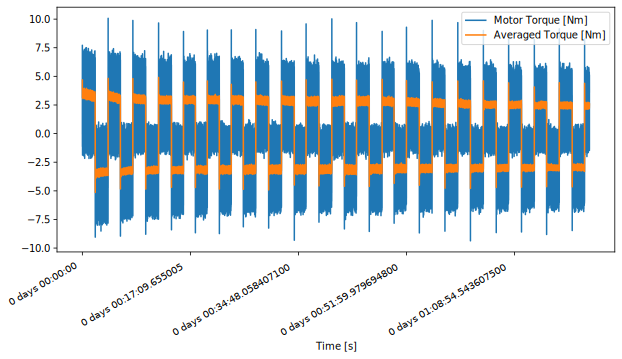

In [9]:
tests_base_onyx = actuator_test_data('Baseline (Onyx)')
tests_base_onyx.add_test_moment('initial', [
    'test_data/2024-07-17__15-37-53_run-in_base-onyx_0.35rps.csv',
    'test_data/2024-07-17__15-49-43__torqueramp__base_onyx init1.csv',
    'test_data/2024-07-17__15-54-23__torqueramp__base_onyx init5.csv',
    'test_data/2024-07-17__15-58-39__torqueramp__base_onyx init6.csv'
])
tests_base_onyx.add_runin_tests([
    'test_data/2024-07-17__16-00-53_run-in_base_onyx_0.35rps.csv',
])
tests_base_onyx.add_test_moment('after run-in', [
    'test_data/2024-07-18__10-35-38_speedramp_base_onyx runin_120s.csv',
    'test_data/2024-07-18__10-58-26__torqueramp__base_onyx runin1.csv',
    'test_data/2024-07-18__11-02-28__torqueramp__base_onyx runin5.csv',
    'test_data/2024-07-18__11-17-26__torqueramp__base_onyx runin6.csv',
])

tests_base_onyx.describe()
tests_base_onyx.runin_tests.plot(y=['Motor Torque [Nm]', 'Averaged Torque [Nm]'], secondary_y=['Motor Temperature [c]', 'Controller Temperature'], figsize=(10, 5))
tests_base_onyx.runin_tests

In [19]:
tests_split_onyx = actuator_test_data('Split Pinwheel (Onyx)')
tests_split_onyx.add_test_moment('initial', [
    'test_data/2024-07-18__12-04-16_speedramp_split_onyx init_120s.csv',
    'test_data/2024-07-18__12-13-03__torqueramp__split_onyx init1.csv',
    'test_data/2024-07-18__12-22-04__torqueramp__split_onyx init5.csv',
    'test_data/2024-07-18__12-26-01__torqueramp__split_onyx init6.csv',
])
tests_split_onyx.add_runin_tests([
    'test_data/2024-07-18__12-32-09_run-in_split_onyx_0.35rps.csv',
])
tests_split_onyx.add_test_moment('after run-in', [
    'test_data/2024-07-18__16-21-56_speedramp_split_onyx runin_120s.csv',
    'test_data/2024-07-18__16-28-57__torqueramp__split_onyx runin1.csv',
    'test_data/2024-07-18__16-32-24__torqueramp__split_onyx runin5.csv',
    'test_data/2024-07-18__16-49-32__torqueramp__split_onyx runin6.csv',
])
tests_split_onyx.add_test_moment('preload increase 1', [
    'test_data/2024-07-18__16-54-19_speedramp_split_onyx 1pre_120s.csv',
    'test_data/2024-07-18__16-58-28__torqueramp__split_onyx 1pre1.csv',
    'test_data/2024-07-18__17-03-34__torqueramp__split_onyx 1pre5.csv',
    'test_data/2024-07-18__17-08-06__torqueramp__split_onyx 1pre6.csv',
])
tests_split_onyx.add_test_moment('preload increase 2', [
    # 'test_data/2024-07-18__17-13-19_speedramp_split_onyx 2pre_120s.csv',
    'test_data/2024-07-18__17-16-14_speedramp_split_onyx 2pre redo_120s.csv',
    'test_data/2024-07-18__17-20-15__torqueramp__split_onyx 2pre1.csv',
    'test_data/2024-07-18__17-23-41__torqueramp__split_onyx 2pre5.csv',
    'test_data/2024-07-18__17-26-47__torqueramp__split_onyx 2pre6.csv',
])
tests_split_onyx.add_test_moment('preload increase 3', [
    'test_data/2024-07-18__17-32-11_speedramp_split_onyx 3pre_120s.csv',
    'test_data/2024-07-18__17-36-03__torqueramp__split_onyx 3pre1.csv',
    'test_data/2024-07-18__17-40-43__torqueramp__split_onyx 3pre5.csv',
    'test_data/2024-07-18__17-45-38__torqueramp__split_onyx 3pre6.csv',
])
tests_split_onyx.add_test_moment('preload increase 4', [
    'test_data/2024-07-18__17-54-06_speedramp_split_onyx 4pre_120s.csv',
    'test_data/2024-07-18__18-00-07__torqueramp__split_onyx 4pre1.csv',
    'test_data/2024-07-18__18-03-49__torqueramp__split_onyx 4pre5.csv',
    'test_data/2024-07-18__18-06-57__torqueramp__split_onyx 4pre6.csv',
])
tests_split_onyx.add_test_moment('preload increase 5', [
    'test_data/2024-07-18__18-11-55_speedramp_split_onyx 5pre_120s.csv',
    'test_data/2024-07-18__18-15-26__torqueramp__split_onyx 5pre1.csv',
    'test_data/2024-07-18__18-18-30__torqueramp__split_onyx 5pre5.csv',
    'test_data/2024-07-18__18-21-33__torqueramp__split_onyx 5pre6.csv',
])
tests_split_onyx.add_test_moment('preload increase 6', [
    'test_data/2024-07-18__18-26-39_speedramp_split_onyx 6pre_120s.csv',
    'test_data/2024-07-18__18-30-11__torqueramp__split_onyx 6pre1.csv',
    'test_data/2024-07-18__18-33-20__torqueramp__split_onyx 6pre5.csv',
    'test_data/2024-07-18__18-36-30__torqueramp__split_onyx 6pre6.csv',
])
tests_split_onyx.add_test_moment('preload increase 7', [
    'test_data/2024-07-19__11-14-16_speedramp_split_onyx 7pre_120s.csv',
    'test_data/2024-07-19__11-18-58__torqueramp__split_onyx 7pre1.csv',
    'test_data/2024-07-19__11-22-18__torqueramp__split_onyx 7pre5.csv',
    'test_data/2024-07-19__11-25-41__torqueramp__split_onyx 7pre6.csv',
])
tests_split_onyx.add_test_moment('preload increase 8', [
    'test_data/2024-07-19__11-30-13_speedramp_split_onyx 8pre_120s.csv',
    'test_data/2024-07-19__11-35-25__torqueramp__split_onyx 8pre1.csv',
    'test_data/2024-07-19__11-38-44__torqueramp__split_onyx 8pre5.csv',
    'test_data/2024-07-19__11-41-55__torqueramp__split_onyx 8pre6.csv',
])
tests_split_onyx.add_test_moment('preload increase 9', [
    'test_data/2024-07-19__11-48-19_speedramp_split_onyx 9pre_120s.csv',
    'test_data/2024-07-19__11-52-46__torqueramp__split_onyx 9pre1.csv',
    'test_data/2024-07-19__11-56-19__torqueramp__split_onyx 9pre5.csv',
    'test_data/2024-07-19__11-59-31__torqueramp__split_onyx 9pre6.csv',
])
tests_split_onyx.add_test_moment('preload increase 10', [
    'test_data/2024-07-19__12-05-03_speedramp_split_onyx 10pre_120s.csv',
    'test_data/2024-07-19__12-13-32__torqueramp__split_onyx 10pre1.csv',
    'test_data/2024-07-19__12-17-03__torqueramp__split_onyx 10pre5.csv',
    'test_data/2024-07-19__12-10-03__torqueramp__split_onyx 10pre6.csv',
])
tests_split_onyx.add_test_moment('preload increase 11', [
    'test_data/2024-07-19__12-21-39_speedramp_split_onyx 11pre_120s.csv',
    'test_data/2024-07-19__12-25-42__torqueramp__split_onyx 11pre1.csv',
    'test_data/2024-07-19__12-30-41__torqueramp__split_onyx 11pre5.csv',
    'test_data/2024-07-19__12-36-11__torqueramp__split_onyx 11pre6.csv',
])
tests_split_onyx.add_test_moment('preload increase 12', [
    'test_data/2024-07-19__12-42-30_speedramp_split_onyx 12pre_120s.csv',
    'test_data/2024-07-19__12-45-43__torqueramp__split_onyx 12pre1.csv',
    'test_data/2024-07-19__12-49-55__torqueramp__split_onyx 12pre5.csv',
    'test_data/2024-07-19__12-54-36__torqueramp__split_onyx 12pre6.csv',
])

tests_split_onyx.describe()


loaded test_data/2024-07-18__12-13-03__torqueramp__split_onyx init1.csv.	 Test postion: -1.95 deg
loaded test_data/2024-07-18__12-22-04__torqueramp__split_onyx init5.csv.	 Test postion: 11.95 deg
loaded test_data/2024-07-18__12-26-01__torqueramp__split_onyx init6.csv.	 Test postion: -5.83 deg
loaded test_data/2024-07-18__12-04-16_speedramp_split_onyx init_120s.csv.
loaded 1 run-in tests, measured time: 0 days 01:28:14.930357600
loaded test_data/2024-07-18__16-28-57__torqueramp__split_onyx runin1.csv.	 Test postion: -1.50 deg
loaded test_data/2024-07-18__16-32-24__torqueramp__split_onyx runin5.csv.	 Test postion: 11.79 deg
loaded test_data/2024-07-18__16-49-32__torqueramp__split_onyx runin6.csv.	 Test postion: -5.66 deg
loaded test_data/2024-07-18__16-21-56_speedramp_split_onyx runin_120s.csv.
loaded test_data/2024-07-18__16-58-28__torqueramp__split_onyx 1pre1.csv.	 Test postion: -3.02 deg
loaded test_data/2024-07-18__17-03-34__torqueramp__split_onyx 1pre5.csv.	 Test postion: 11.13 deg


In [15]:
tests_conic_onyx = actuator_test_data('Conic Disk (Onyx)')
tests_conic_onyx.add_test_moment('initial', [
    # 'test_data/2024-07-18__14-16-00_speedramp_cone_onyx init_120s.csv',
    'test_data/2024-07-18__14-18-36_speedramp_conic_onyx init_120s.csv',
    'test_data/2024-07-18__14-28-32__torqueramp__conic_onyx init1.csv',
    'test_data/2024-07-18__14-38-06__torqueramp__conic_onyx init5.csv',
    'test_data/2024-07-18__14-43-54__torqueramp__conic_onyx init6.csv',
])
tests_conic_onyx.add_runin_tests([
    'test_data/2024-07-18__14-46-11_run-in_conic_onyx_0.35rps.csv',
])
tests_conic_onyx.add_test_moment('after run-in', [
    'test_data/2024-07-19__13-01-08_speedramp_conic_onyx runin_120s.csv',
    # 'test_data/2024-07-19__13-05-35__torqueramp__conic_onyx runin1.csv',
    'test_data/2024-07-19__13-07-36__torqueramp__conic_onyx runin1.csv',
    'test_data/2024-07-19__13-10-53__torqueramp__conic_onyx runin5.csv',
    'test_data/2024-07-19__13-15-33__torqueramp__conic_onyx runin6.csv',
])


loaded test_data/2024-07-18__14-28-32__torqueramp__conic_onyx init1.csv.	 Test postion:  2.22 deg
loaded test_data/2024-07-18__14-38-06__torqueramp__conic_onyx init5.csv.	 Test postion: -11.06 deg
loaded test_data/2024-07-18__14-43-54__torqueramp__conic_onyx init6.csv.	 Test postion: -0.69 deg
loaded test_data/2024-07-18__14-18-36_speedramp_conic_onyx init_120s.csv.
loaded 1 run-in tests, measured time: 0 days 01:31:50.694483500


# data visualization

    initial             : 	 Coulomb Friction [Nm]:  2.684,	 coulomb_neg: -2.468,	 coulomb_pos:  2.899
    after run-in        : 	 Coulomb Friction [Nm]:  1.874,	 coulomb_neg: -1.703,	 coulomb_pos:  2.045
    initial             : 	 Coulomb Friction [Nm]:  2.703,	 coulomb_neg: -2.456,	 coulomb_pos:  2.949
    after run-in        : 	 Coulomb Friction [Nm]:  2.865,	 coulomb_neg: -2.583,	 coulomb_pos:  3.147
    preload increase 1  : 	 Coulomb Friction [Nm]:  3.872,	 coulomb_neg: -3.189,	 coulomb_pos:  4.556
    preload increase 2  : 	 Coulomb Friction [Nm]:  4.963,	 coulomb_neg: -4.083,	 coulomb_pos:  5.842
    preload increase 3  : 	 Coulomb Friction [Nm]:  6.439,	 coulomb_neg: -5.348,	 coulomb_pos:  7.531
    preload increase 4  : 	 Coulomb Friction [Nm]:  8.757,	 coulomb_neg: -6.810,	 coulomb_pos: 10.703
    preload increase 5  : 	 Coulomb Friction [Nm]:  9.568,	 coulomb_neg: -8.006,	 coulomb_pos: 11.130
    initial             : 	 Coulomb Friction [Nm]:  2.710,	 coulomb_neg: -2.542,	 

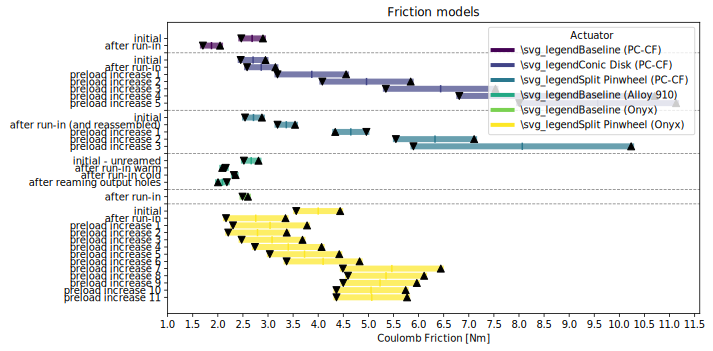

,actuator,test,Coulomb Friction [Nm],coulomb_neg,coulomb_pos
initial,Baseline (PC-CF),initial,2.683543,-2.467797,2.89929
after run-in,Baseline (PC-CF),after run-in,1.873951,-1.703157,2.044744
initial,Conic Disk (PC-CF),initial,2.70265,-2.456094,2.949206
after run-in,Conic Disk (PC-CF),after run-in,2.865098,-2.583195,3.147002
preload increase 1,Conic Disk (PC-CF),preload increase 1,3.872213,-3.188892,4.555535
preload increase 2,Conic Disk (PC-CF),preload increase 2,4.962572,-4.08267,5.842474
preload increase 3,Conic Disk (PC-CF),preload increase 3,6.43935,-5.348072,7.530629
preload increase 4,Conic Disk (PC-CF),preload increase 4,8.756533,-6.810397,10.702669
preload increase 5,Conic Disk (PC-CF),preload increase 5,9.568204,-8.006211,11.130197
initial,Split Pinwheel (PC-CF),initial,2.710397,-2.542353,2.878441


In [20]:
actuators = [tests_base_pccf, tests_conic_pccf, tests_split_pccf, tests_base_910, tests_base_onyx, tests_split_onyx]

def estimate_friction(df):
    pos_df = df[df['Motor Speed [rpm]'] > 0.05]
    neg_df = df[df['Motor Speed [rpm]'] < 0.05]

    pos_coulomb = pos_df['Motor Torque [Nm]'].mean()
    neg_coulomb = neg_df['Motor Torque [Nm]'].mean()
    coulomb = (pos_coulomb - neg_coulomb) / 2

    results = {
        'Coulomb Friction [Nm]': coulomb,
        'coulomb_neg': neg_coulomb,
        'coulomb_pos': pos_coulomb,
    }
    return results


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.set_title('Friction models')

num_tests = sum([len(actuator.speed_ramps) for actuator in actuators])
num_bars = num_tests + len(actuators) - 1
bar_width = 0.8  # Adjust bar width for visibility within groups
bar_pos = num_bars
labels = []
colors = plt.cm.viridis(np.linspace(0, 1, len(actuators)))

results_df = pd.DataFrame()
for i, actuator in enumerate(actuators):
    results_dict = {}
    for j, (name, df) in enumerate(actuator.speed_ramps.items()):
        fric_results = estimate_friction(df)
        results = {'actuator': actuator.configuration, 'test': name, **fric_results}
        results_dict[name] = {**results, **results_dict.get(name, {})}
        print(f'    {name:20}: \t', ',\t '.join([f'{k}:{v:7.3f}' for k, v in fric_results.items()]))

        # for each test plot the friction. neg and pos should form a bar, while the average is added as a line
        # ax.barh(bar_pos, fric_results['Coulomb Friction [Nm]'], 0.3, color=colors[i], label=name)
        # ax.barh(bar_pos, -fric_results['Coulomb Friction [Nm]'], 0.3, color=colors[i], label=name)
        # ax.barh(bar_pos, fric_results['coulomb_neg'], 0.9,  color=colors[i], alpha=0.5)
        # ax.barh(bar_pos, fric_results['coulomb_pos'], 0.9, color=colors[i], alpha=0.5)

        ax.plot((-fric_results['coulomb_neg'], fric_results['coulomb_pos']), (bar_pos, bar_pos), color=colors[i], linewidth=6, alpha=0.7, label='_')
        ax.plot((fric_results['Coulomb Friction [Nm]'], fric_results['Coulomb Friction [Nm]']), (bar_pos-0.4, bar_pos+0.4), color=colors[i], label='_')
        # indicate positive side
        ax.plot(fric_results['coulomb_pos'], bar_pos, '^', color='black', label='positive', markersize=7)
        ax.plot(-fric_results['coulomb_neg'], bar_pos, 'v', color='black', label='negative', markersize=7)


        bar_pos -= 1
        labels.append(name)
        
    if i < len(actuators) - 1:
        ax.axhline(bar_pos, color='gray', linewidth=0.8, linestyle='--')
        bar_pos -= 1
        labels.append('')

    results_df = pd.concat([results_df, pd.DataFrame(results_dict).T])

handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(len(actuators))]
ax.legend(handles, [f'\svg_legend{actuator.configuration}' for actuator in actuators], title='Actuator', loc='upper right')


ax.set_yticks(np.arange(1, len(labels)+1))
ax.set_yticklabels(reversed(labels))
# ax.legend([a.configuration for a in actuators], title='Actuator')
# ax.grid()
ax.set_xticks(np.arange(1.0, 12, 0.5))
ax.set_xlabel('Coulomb Friction [Nm]')

fig.tight_layout()

fig.savefig(f'figures/friction barplot.svg')
plt.show()


results_df



Split Pinwheel undersized (PC-CF)

initial
    Test combined: 	 Play [deg]:  0.918,	 Stiffness [deg/Nm]:  0.096,	 pos_stiffness:  0.106,	 neg_stiffness:  0.086

after run-in
    Test combined: 	 Play [deg]:  0.922,	 Stiffness [deg/Nm]:  0.099,	 pos_stiffness:  0.092,	 neg_stiffness:  0.106

preload increase 1
    Test combined: 	 Play [deg]:  1.059,	 Stiffness [deg/Nm]:  0.095,	 pos_stiffness:  0.089,	 neg_stiffness:  0.102

preload increase 2
    Test combined: 	 Play [deg]:  0.928,	 Stiffness [deg/Nm]:  0.082,	 pos_stiffness:  0.080,	 neg_stiffness:  0.084

preload increase 3
    Test combined: 	 Play [deg]:  0.840,	 Stiffness [deg/Nm]:  0.082,	 pos_stiffness:  0.084,	 neg_stiffness:  0.080

preload increase 4
    Test combined: 	 Play [deg]:  0.654,	 Stiffness [deg/Nm]:  0.080,	 pos_stiffness:  0.080,	 neg_stiffness:  0.080

Speed ramps:
    initial             : 	 Coulomb Friction [Nm]:  3.102,	 coulomb_neg: -2.418,	 coulomb_pos:  3.787
    after run-in        : 	 Coulomb Frictio

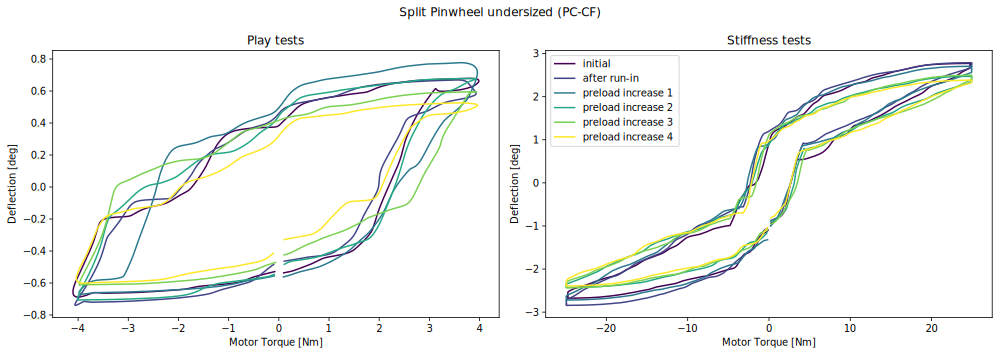



Baseline (PC-CF)

initial
    Test combined: 	 Play [deg]:  2.556,	 Stiffness [deg/Nm]:  0.084,	 pos_stiffness:  0.075,	 neg_stiffness:  0.093

after run-in
    Test combined: 	 Play [deg]:  2.501,	 Stiffness [deg/Nm]:  0.083,	 pos_stiffness:  0.076,	 neg_stiffness:  0.089

Speed ramps:
    initial             : 	 Coulomb Friction [Nm]:  2.684,	 coulomb_neg: -2.468,	 coulomb_pos:  2.899
    after run-in        : 	 Coulomb Friction [Nm]:  1.874,	 coulomb_neg: -1.703,	 coulomb_pos:  2.045


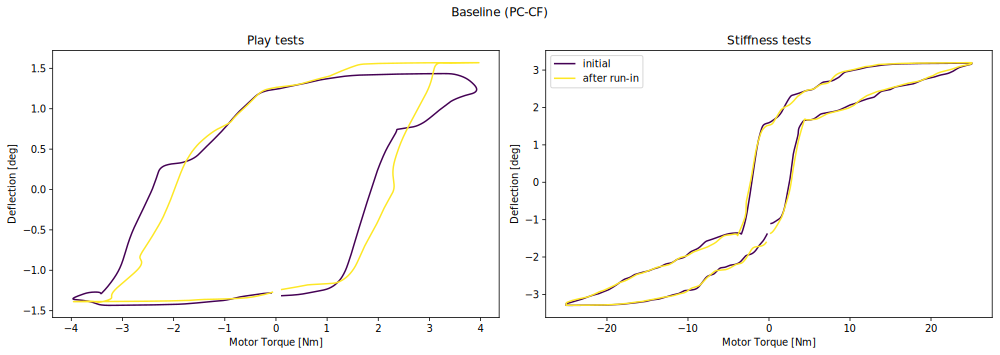



Conic Disk (PC-CF)

initial
    Test combined: 	 Play [deg]:  0.779,	 Stiffness [deg/Nm]:  0.106,	 pos_stiffness:  0.106,	 neg_stiffness:  0.106

after run-in
    Test combined: 	 Play [deg]:  1.474,	 Stiffness [deg/Nm]:  0.103,	 pos_stiffness:  0.103,	 neg_stiffness:  0.103

preload increase 1
    Test combined: 	 Play [deg]:  0.859,	 Stiffness [deg/Nm]:  0.106,	 pos_stiffness:  0.104,	 neg_stiffness:  0.108

preload increase 2
    Test combined: 	 Play [deg]:  0.693,	 Stiffness [deg/Nm]:  0.100,	 pos_stiffness:  0.097,	 neg_stiffness:  0.103

preload increase 3
    Test combined: 	 Play [deg]:  0.552,	 Stiffness [deg/Nm]:  0.097,	 pos_stiffness:  0.098,	 neg_stiffness:  0.096

preload increase 4
    Test combined: 	 Play [deg]:  0.481,	 Stiffness [deg/Nm]:  0.091,	 pos_stiffness:  0.091,	 neg_stiffness:  0.091

preload increase 5
    Test combined: 	 Play [deg]:  0.481,	 Stiffness [deg/Nm]:  0.094,	 pos_stiffness:  0.094,	 neg_stiffness:  0.094

Speed ramps:
    initial            

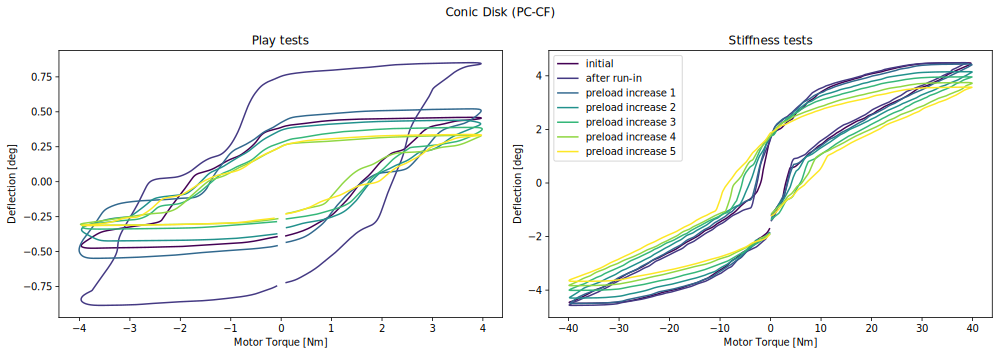



Split Pinwheel (PC-CF)

initial
    Test combined: 	 Play [deg]:  1.004,	 Stiffness [deg/Nm]:  0.100,	 pos_stiffness:  0.098,	 neg_stiffness:  0.103

after run-in (and reassembled)
    Test combined: 	 Play [deg]:  1.559,	 Stiffness [deg/Nm]:  0.091,	 pos_stiffness:  0.092,	 neg_stiffness:  0.089

preload increase 1
    Test combined: 	 Play [deg]:  0.581,	 Stiffness [deg/Nm]:  0.092,	 pos_stiffness:  0.091,	 neg_stiffness:  0.093

preload increase 2
    Test combined: 	 Play [deg]:  0.208,	 Stiffness [deg/Nm]:  0.089,	 pos_stiffness:  0.090,	 neg_stiffness:  0.088

preload increase 3
    Test combined: 	 Play [deg]:  0.121,	 Stiffness [deg/Nm]:  0.090,	 pos_stiffness:  0.086,	 neg_stiffness:  0.095

Speed ramps:
    initial             : 	 Coulomb Friction [Nm]:  2.710,	 coulomb_neg: -2.542,	 coulomb_pos:  2.878
    after run-in (and reassembled): 	 Coulomb Friction [Nm]:  3.364,	 coulomb_neg: -3.190,	 coulomb_pos:  3.538
    preload increase 1  : 	 Coulomb Friction [Nm]:  4.650,	 c

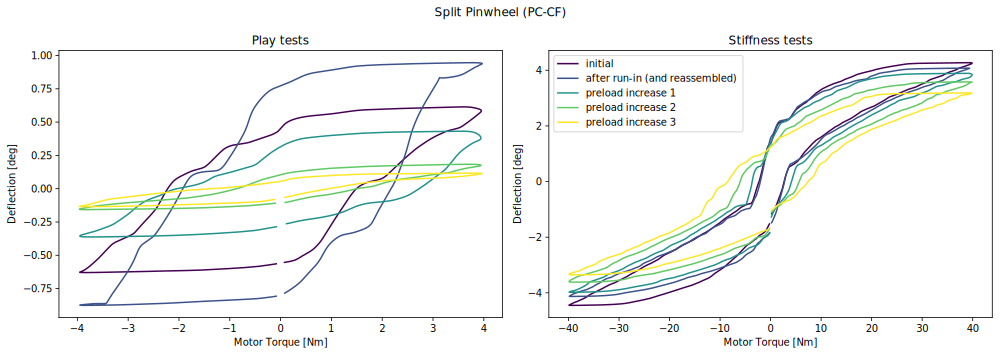



Baseline (Alloy 910)

initial - unreamed
    Test combined: 	 Play [deg]:  1.355,	 Stiffness [deg/Nm]:  0.152,	 pos_stiffness:  0.140,	 neg_stiffness:  0.163

after run-in warm
    Test combined: 	 Play [deg]:  2.152,	 Stiffness [deg/Nm]:  0.322,	 pos_stiffness:  0.292,	 neg_stiffness:  0.352

after run-in cold
    Test combined: 	 Play [deg]:  2.195,	 Stiffness [deg/Nm]:  0.180,	 pos_stiffness:  0.188,	 neg_stiffness:  0.171

after reaming output holes
    Test combined: 	 Play [deg]:  1.720,	 Stiffness [deg/Nm]:  0.151,	 pos_stiffness:  0.137,	 neg_stiffness:  0.164

Speed ramps:
    initial - unreamed  : 	 Coulomb Friction [Nm]:  2.665,	 coulomb_neg: -2.520,	 coulomb_pos:  2.810
    after run-in warm   : 	 Coulomb Friction [Nm]:  2.123,	 coulomb_neg: -2.158,	 coulomb_pos:  2.088
    after run-in cold   : 	 Coulomb Friction [Nm]:  2.337,	 coulomb_neg: -2.320,	 coulomb_pos:  2.354
    after reaming output holes: 	 Coulomb Friction [Nm]:  2.092,	 coulomb_neg: -2.180,	 coulomb_pos:  2

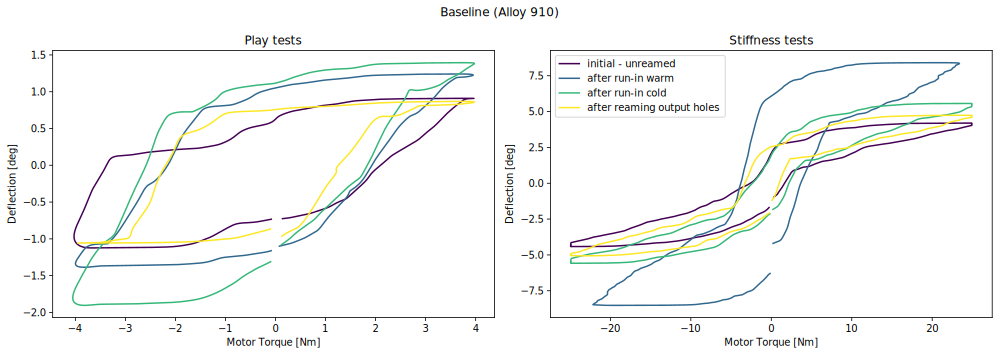



Baseline (Onyx)

initial
    Test combined: 	 Play [deg]:  0.988,	 Stiffness [deg/Nm]:  0.169,	 pos_stiffness:  0.161,	 neg_stiffness:  0.177

after run-in
    Test combined: 	 Play [deg]:  1.444,	 Stiffness [deg/Nm]:  0.171,	 pos_stiffness:  0.165,	 neg_stiffness:  0.177

Speed ramps:
    after run-in        : 	 Coulomb Friction [Nm]:  2.546,	 coulomb_neg: -2.492,	 coulomb_pos:  2.600


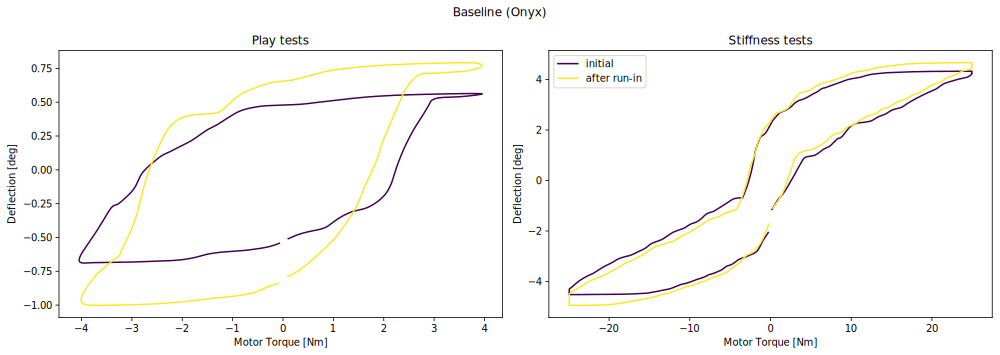



Split Pinwheel (Onyx)

initial
    Test combined: 	 Play [deg]:  0.476,	 Stiffness [deg/Nm]:  0.190,	 pos_stiffness:  0.198,	 neg_stiffness:  0.183

after run-in
    Test combined: 	 Play [deg]:  1.147,	 Stiffness [deg/Nm]:  0.187,	 pos_stiffness:  0.187,	 neg_stiffness:  0.187

preload increase 1
    Test combined: 	 Play [deg]:  1.105,	 Stiffness [deg/Nm]:  0.203,	 pos_stiffness:  0.205,	 neg_stiffness:  0.201

preload increase 2
    Test combined: 	 Play [deg]:  1.354,	 Stiffness [deg/Nm]:  0.223,	 pos_stiffness:  0.218,	 neg_stiffness:  0.229

preload increase 3
    Test combined: 	 Play [deg]:  0.802,	 Stiffness [deg/Nm]:  0.231,	 pos_stiffness:  0.227,	 neg_stiffness:  0.235

preload increase 4
    Test combined: 	 Play [deg]:  0.949,	 Stiffness [deg/Nm]:  0.217,	 pos_stiffness:  0.215,	 neg_stiffness:  0.219

preload increase 5
    Test combined: 	 Play [deg]:  0.513,	 Stiffness [deg/Nm]:  0.230,	 pos_stiffness:  0.235,	 neg_stiffness:  0.224

preload increase 6
    Test combi

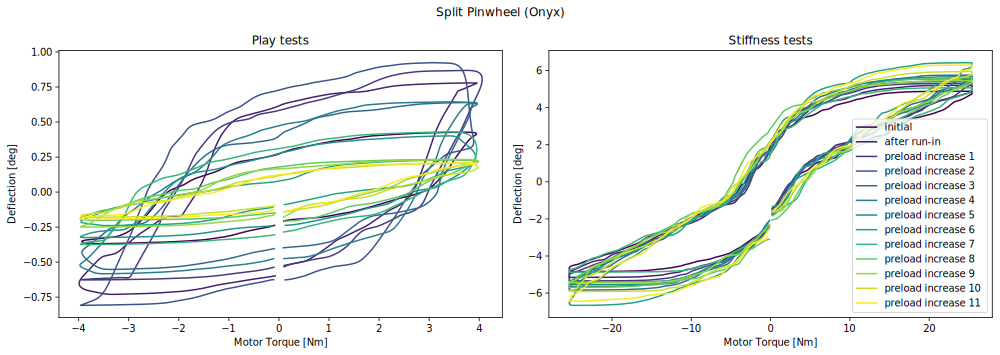



Conic Disk (Onyx)

initial
    Test combined: 	 Play [deg]:  0.788,	 Stiffness [deg/Nm]:  0.206,	 pos_stiffness:  0.181,	 neg_stiffness:  0.230

Speed ramps:
    initial             : 	 Coulomb Friction [Nm]:  6.013,	 coulomb_neg: -4.826,	 coulomb_pos:  7.201


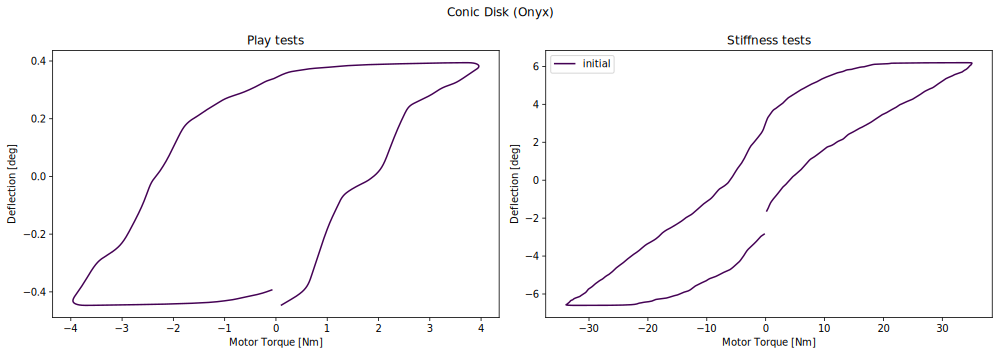

,actuator,test,Coulomb Friction [Nm],coulomb_neg,coulomb_pos,Play [deg],Stiffness [deg/Nm],pos_stiffness,neg_stiffness,test_nr
initial,Split Pinwheel undersized (PC-CF),initial,3.102428,-2.417842,3.787014,0.917787,0.095873,0.105637,0.086108,0
after run-in,Split Pinwheel undersized (PC-CF),after run-in,2.543697,-2.190899,2.896495,0.922267,0.09873,0.091802,0.105657,1
preload increase 1,Split Pinwheel undersized (PC-CF),preload increase 1,3.131556,-3.024582,3.238529,1.058826,0.095371,0.089199,0.101544,2
preload increase 2,Split Pinwheel undersized (PC-CF),preload increase 2,4.667329,-4.430089,4.904569,0.92782,0.082001,0.080032,0.083971,3
preload increase 3,Split Pinwheel undersized (PC-CF),preload increase 3,4.324869,-4.562234,4.087504,0.840494,0.082023,0.0843,0.079747,4
preload increase 4,Split Pinwheel undersized (PC-CF),preload increase 4,4.201069,-4.650881,3.751258,0.654085,0.080044,0.08021,0.079878,5
preload increase 5,Split Pinwheel undersized (PC-CF),preload increase 5,3.843646,-4.487572,3.19972,NaN,NaN,NaN,NaN,NaN
initial,Baseline (PC-CF),initial,2.683543,-2.467797,2.89929,2.55616,0.083896,0.074909,0.092882,0
after run-in,Baseline (PC-CF),after run-in,1.873951,-1.703157,2.044744,2.501479,0.082509,0.075599,0.08942,1
initial,Conic Disk (PC-CF),initial,2.70265,-2.456094,2.949206,0.778611,0.106327,0.106375,0.10628,0


In [21]:
actuators = [tests_split_pccf_u, tests_base_pccf, tests_conic_pccf, tests_split_pccf, tests_base_910, tests_base_onyx, tests_split_onyx, tests_conic_onyx]

def estimate_play_and_stiffness(play_test, stiffness_test):
    def get_rising_slopes(df):
        # split data in to positive and negative slopes. remove the hysteresis part
        max_torque_idx = df['Desired Torque [Nm]'].idxmax()
        pos_slope = df.loc[:max_torque_idx]

        # find zero crossing of desired torque
        min_torque_idx = df['Desired Torque [Nm]'].idxmin()
        zero_torque_idx = df['Desired Torque [Nm]'][max_torque_idx:min_torque_idx].abs().idxmin()
        neg_slope = df.loc[zero_torque_idx:min_torque_idx]

        return pos_slope, neg_slope

    # estimate play
    play_pos_slope, play_neg_slope = get_rising_slopes(play_test)
    pos_play = play_pos_slope['Deflection [deg]'].iloc[0]
    neg_play = play_neg_slope['Deflection [deg]'].iloc[0]
    play = neg_play - pos_play
    # print(f'Play: {play} deg ({pos_play} pos, {neg_play} neg)')

    # estimate stiffness
    stiffness_pos_slope, stiffness_neg_slope = get_rising_slopes(stiffness_test)
    stiffness_pos_slope = stiffness_pos_slope[stiffness_pos_slope['Deflection [deg]'] > neg_play]
    stiffness_neg_slope = stiffness_neg_slope[stiffness_neg_slope['Deflection [deg]'] < pos_play]

    # do polyfit
    pos_stiffness, pos_offset = np.polyfit(stiffness_pos_slope['Motor Torque [Nm]'], stiffness_pos_slope['Deflection [deg]'], 1)
    neg_stiffness, neg_offset = np.polyfit(stiffness_neg_slope['Motor Torque [Nm]'], stiffness_neg_slope['Deflection [deg]'], 1)

    # print(f'Positive stiffness: {pos_stiffness} deg/Nm, offset: {pos_offset} deg')
    # print(f'Negative stiffness: {neg_stiffness} deg/Nm, offset: {neg_offset} deg')

    results = {
        'Play [deg]': play,
        'Stiffness [deg/Nm]': (pos_stiffness + neg_stiffness) / 2,
        'pos_stiffness': pos_stiffness,
        'neg_stiffness': neg_stiffness,
    }
    return results

def estimate_friction_coeff(df):
    # split data in positive and negative velocity
    positive_vt = df[df['Motor Speed [rpm]'] > 0]
    negative_vt = df[df['Motor Speed [rpm]'] < 0]

    MAX_SPEED = 0.4
    positive_vt = positive_vt[positive_vt['Motor Speed [rpm]'] < MAX_SPEED]
    negative_vt = negative_vt[negative_vt['Motor Speed [rpm]'] > -MAX_SPEED]

    # fit linear model
    pos_viscous, pos_coulomb,  = np.polyfit(positive_vt['Motor Speed [rpm]'], positive_vt['Motor Torque [Nm]'], 1)
    neg_viscous, neg_coulomb,  = np.polyfit(negative_vt['Motor Speed [rpm]'], negative_vt['Motor Torque [Nm]'], 1)

    # average
    coulomb = (pos_coulomb - neg_coulomb) / 2
    viscous = (pos_viscous + neg_viscous) / 2
    # print(f'coulomb: {coulomb:.5f}[Nm], ({pos_coulomb:.5f}, {neg_coulomb:.5f})')
    # print(f'viscous: {viscous:.5f} [Nm/(rev/s)], ({pos_viscous:.5f}, {neg_viscous:.5f})')

    results = {
        'Coulomb Friction [Nm]': coulomb,
        'coulomb_neg': neg_coulomb,
        'coulomb_pos': pos_coulomb,
        'Viscous Friction [Nm.s/rev]': viscous,
        'viscous_neg': neg_viscous,
        'viscous_pos': pos_viscous,
    }
    return results

def estimate_friction(df):
    pos_df = df[df['Motor Speed [rpm]'] > 0.05]
    neg_df = df[df['Motor Speed [rpm]'] < 0.05]

    pos_coulomb = pos_df['Motor Torque [Nm]'].mean()
    neg_coulomb = neg_df['Motor Torque [Nm]'].mean()
    coulomb = (pos_coulomb - neg_coulomb) / 2

    results = {
        'Coulomb Friction [Nm]': coulomb,
        'coulomb_neg': neg_coulomb,
        'coulomb_pos': pos_coulomb,
    }
    return results


results_df = pd.DataFrame()
for actuator in actuators:
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(actuator.configuration)
    axs[0].set_title('Play tests')
    axs[1].set_title('Stiffness tests')
    # axs[2].set_title('Friction models')
    axs[0].set_xlabel('Motor Torque [Nm]')
    axs[0].set_ylabel('Deflection [deg]')
    axs[1].set_xlabel('Motor Torque [Nm]')
    axs[1].set_ylabel('Deflection [deg]')
    # axs[2].set_ylabel('Friction Torque [Nm]')

    print(f'\n\n{actuator.configuration}')
    
    results_dict = {}
    colors = plt.cm.viridis(np.linspace(0, 1, len(actuator.torque_ramps)))
    for i, (name, ramps) in enumerate(actuator.torque_ramps.items()):
        print(f'\n{name}')

        #plot curves
        (play_test_mean, stiffness_test_mean) = ramps['combined']

        # play_test_mean.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[0], label=name, color=colors[i])
        # stiffness_test_mean.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[1], label=name, color=colors[i])

        axs[0].plot(play_test_mean['Motor Torque [Nm]'], play_test_mean['Deflection [deg]'], label=name, color=colors[i])
        axs[1].plot(stiffness_test_mean['Motor Torque [Nm]'], stiffness_test_mean['Deflection [deg]'], label=name, color=colors[i])

        torque_results = estimate_play_and_stiffness(play_test_mean, stiffness_test_mean)
        results = {**torque_results, 'actuator': actuator.configuration, 'test': name, 'test_nr': i}

        print(f'    Test combined: \t', ',\t '.join([f'{k}:{v:7.3f}' for k, v in torque_results.items()]))

        results_dict[name] = results
    # axs[0].legend()
    axs[1].legend()

    print(f'\nSpeed ramps:')
    colors = plt.cm.viridis(np.linspace(0, 1, len(actuator.speed_ramps)))
    for i, (name, df) in enumerate(actuator.speed_ramps.items()):
        fric_results = estimate_friction(df)
        results = {'actuator': actuator.configuration, 'test': name, **fric_results}
        results_dict[name] = {**results, **results_dict.get(name, {})}
        print(f'    {name:20}: \t', ',\t '.join([f'{k}:{v:7.3f}' for k, v in fric_results.items()]))

    #     # todo: make this a barplot combining all actuators
    #     speeds_pos = np.linspace(0, df['Motor Speed [rpm]'].max(), 100)
    #     pos_model = pd.DataFrame({'Motor Speed [rpm]': speeds_pos, 'Friction Model': fric_results['viscous_pos'] * speeds_pos + fric_results['coulomb_pos']})
    #     speeds_neg = np.linspace(df['Motor Speed [rpm]'].min(), 0, 100)
    #     neg_model = pd.DataFrame({'Motor Speed [rpm]': speeds_neg, 'Friction Model': fric_results['viscous_neg'] * speeds_neg + fric_results['coulomb_neg']})
    #     friction_model = pd.concat([neg_model, pos_model])
    #     friction_model.plot(x='Motor Speed [rpm]', y='Friction Model', kind='line', ax=axs[2], label=name, color=colors[i])
        
    results_df = pd.concat([results_df, pd.DataFrame(results_dict).T])
    fig.tight_layout()

    fig.savefig(f'figures/torque-displacement of {actuator.configuration}.svg')
    plt.show()


results_df

# data averaging example

Torque ramp repeats a torque increase in alternating diction for multiple itterations. THe following is how those repetitions are averaged into a single curve

[  0   1   2   3   4   5   6 100 101 102 103]
Sample rate: 387.91730982321576 Hz
Orientation: 107.8569304116857 deg
Index(['Motor Torque [Nm]', 'Deflection [deg]', 'Desired Torque [Nm]',
       'Q_current/5', 'test_nr'],
      dtype='object')


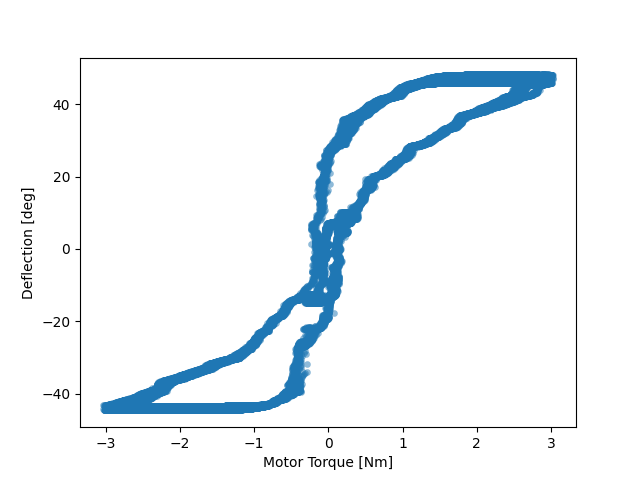

test 0 resampled from 1945 to 10024 samples
test 1 resampled from 1861 to 10029 samples
test 2 resampled from 1926 to 10020 samples
test 3 resampled from 1934 to 10011 samples
test 4 resampled from 1944 to 10017 samples
test 5 resampled from 1948 to 10009 samples
test 6 resampled from 1945 to 10011 samples
setting everything to 10009 samples
test 0 resampled from 10877 to 56027 samples
test 1 resampled from 11018 to 56031 samples
test 2 resampled from 10859 to 56028 samples
test 3 resampled from 10864 to 56029 samples
setting everything to 56027 samples


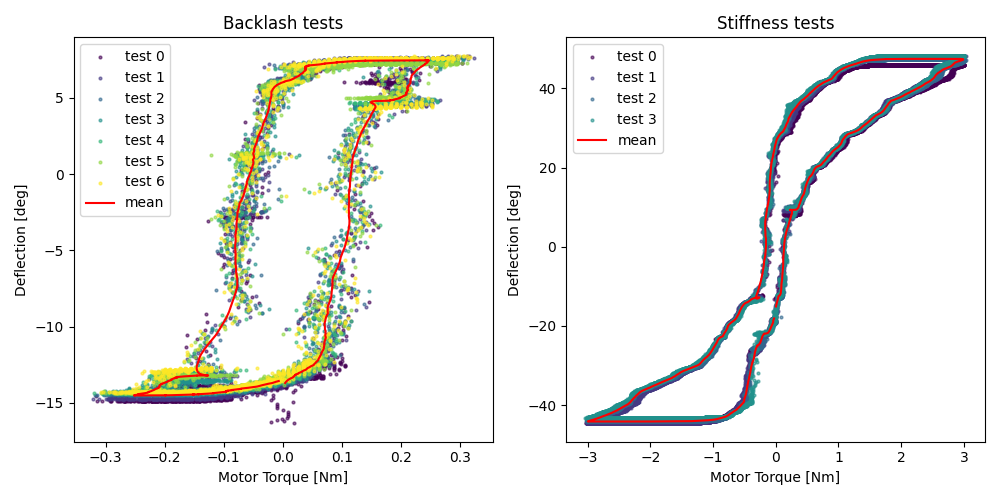

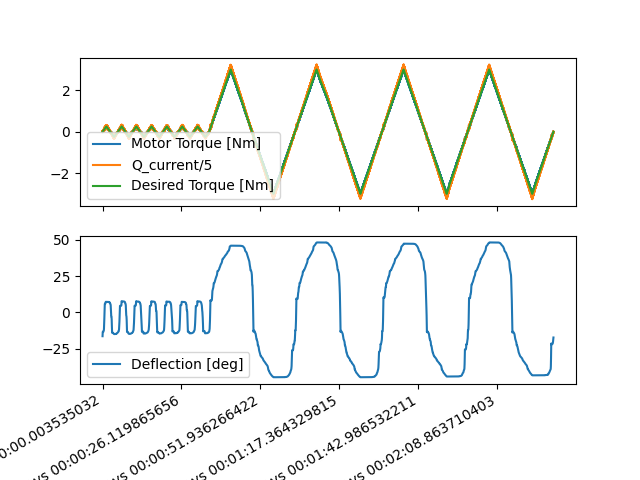

In [ ]:
filename = 'test_data/2024-06-20__16-12-43__torqueramp__Baseline Run-in Reassmeble.csv'    #run-in baseline after reassembly. Calibrated for 20Hz


df_raw = pd.read_csv(filename)
# print(df_raw.head())
print(df_raw['test_nr'].unique())

df = pd.DataFrame()
df['Time [s]'] = df_raw['TIME']
df['Motor Torque [Nm]'] = df_raw['TORQUE']  #.rolling(window=20, center=True).mean()
df['Deflection [deg]'] = df_raw['POSITION'] * 360
df['Desired Torque [Nm]'] = df_raw['CONTROL_TORQUE']
df['Q_current/5'] = df_raw['Q_CURRENT']/5
df['test_nr'] = df_raw['test_nr']

sample_rate = 1/(df['Time [s]'].diff().mean())
# to datetime
df['Time [s]'] = pd.to_timedelta(df['Time [s]'], unit='s')
df.set_index('Time [s]', inplace=True)

orientation = df['Deflection [deg]'].mean()
df['Deflection [deg]'] -= orientation

print(f'Sample rate: {sample_rate} Hz')
print(f'Orientation: {orientation} deg')
print(df.columns)
# print(df.head())

fig, axs = plt.subplots(2, 1, sharex=True)
df.plot(y=['Motor Torque [Nm]', 'Q_current/5', 'Desired Torque [Nm]'], ax=axs[0])
df.plot(y='Deflection [deg]', ax=axs[1])

hyst_ax = df.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='scatter', linewidth=0.2, alpha=0.5)
# df.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=hyst_ax)
plt.show()


def average_data(df):
    data = []
    grouped = df.groupby('test_nr')

    for name, group in grouped:
        group = group.drop('test_nr', axis=1)
        group.index = group.index - group.index[0]

        old_len = len(group)
        group = group.resample('0.5ms').mean()
        group = group.interpolate(method='time')
        print(f'test {name} resampled from {old_len} to {len(group)} samples')

        data.append(group.values)

    # get consistent length
    min_len = min([len(d) for d in data])
    data = [d[:min_len] for d in data]
    print(f'setting everything to {min_len} samples')

    # average data using numpy
    data_mean = np.mean(np.array(data), axis=0)

    new_columns = df.columns.drop('test_nr')
    mean_df = pd.DataFrame(data_mean, columns=new_columns)

    # smooth data
    mean_df = mean_df.rolling(window=100, center=True).mean()
    mean_df = mean_df.bfill().ffill()

    return mean_df

TEST_NR_OFFSET = 100
play_tests = df[df['test_nr'] < TEST_NR_OFFSET].copy()
stiffness_tests = df[df['test_nr'] >= TEST_NR_OFFSET].copy()
stiffness_tests['test_nr'] = stiffness_tests['test_nr'] - TEST_NR_OFFSET

play_test_mean = average_data(play_tests)
stiffness_test_mean = average_data(stiffness_tests)


# plot torque ramp curves for each test, then overlay mean
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# colors = plt.cm.cividis(np.linspace(0, 1, play_tests['test_nr'].max() + 2))
colors = plt.cm.viridis(np.linspace(0, 1, play_tests['test_nr'].max() + 1))

for i in range(play_tests['test_nr'].max() + 1):
    test = play_tests[play_tests['test_nr'] == i]
    color = np.array([colors[i]])
    test.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='scatter', ax=axs[0], alpha=0.6, label=f'test {i}', color=color, s=4)
color = np.array([colors[-1]])
play_test_mean.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[0], label='mean', color='red') 
axs[0].set_title('Backlash tests')

for i in range(stiffness_tests['test_nr'].max() + 1):
    test = stiffness_tests[stiffness_tests['test_nr'] == i]
    color = np.array([colors[i]]) 
    test.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='scatter', ax=axs[1], alpha=0.6, label=f'test {i}', color=color, s=4)
color = np.array([colors[-1]]) 
stiffness_test_mean.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[1], label='mean', color='red')
axs[1].set_title('Stiffness tests')

# save plot
fig.tight_layout()
plt.show()

# play and stiffness calculations

Play: 0.9084378585815431 deg (-0.5475516332815318 pos, 0.36088622530001135 neg)
Positive stiffness: 0.10013583961137597 deg/Nm, offset: 0.5957043437382998 deg
Negative stiffness: 0.10495991686640148 deg/Nm, offset: -0.4945399159044272 deg


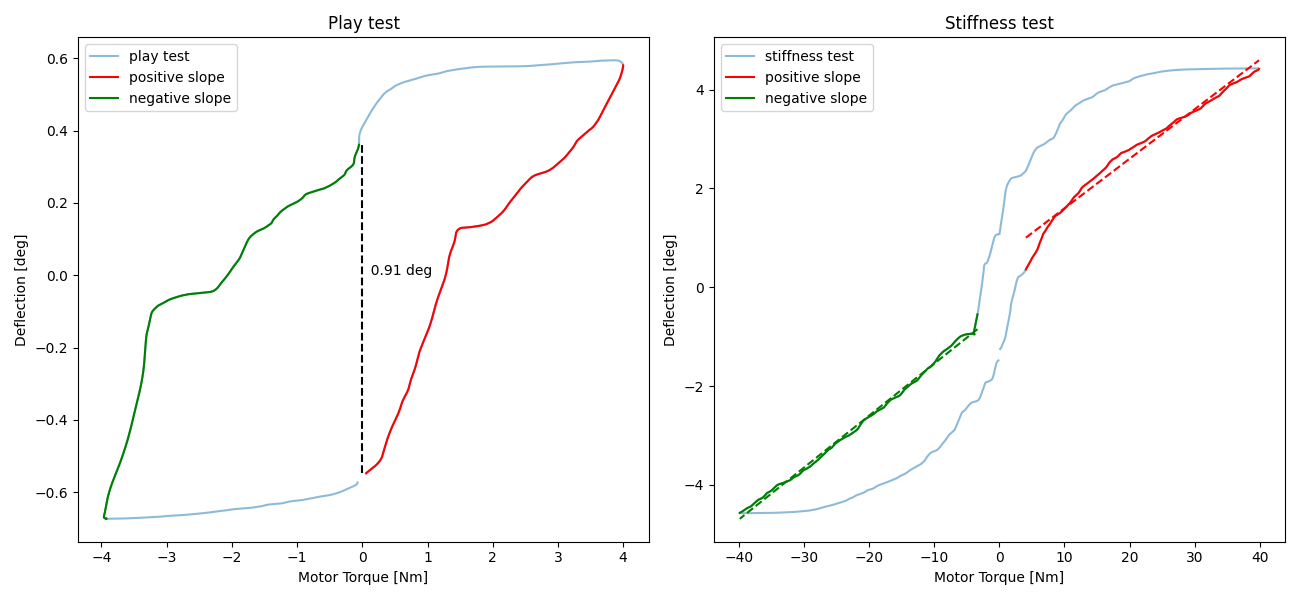

In [ ]:
play_test_mean, stiffness_test_mean = tests_split_pccf.torque_ramps['initial'][1]

def get_rising_slopes(df):
    # split data in to positive and negative slopes. remove the hysteresis part
    max_torque_idx = df['Desired Torque [Nm]'].idxmax()
    pos_slope = df.loc[:max_torque_idx]

    # find zero crossing of desired torque
    min_torque_idx = df['Desired Torque [Nm]'].idxmin()
    zero_torque_idx = df['Desired Torque [Nm]'][max_torque_idx:min_torque_idx].abs().idxmin()
    neg_slope = df.loc[zero_torque_idx:min_torque_idx]

    return pos_slope, neg_slope


# estimate play
play_pos_slope, play_neg_slope = get_rising_slopes(play_test_mean)
pos_play = play_pos_slope['Deflection [deg]'].iloc[0]
neg_play = play_neg_slope['Deflection [deg]'].iloc[0]
print(f'Play: {neg_play-pos_play} deg ({pos_play} pos, {neg_play} neg)')


# estimate stiffness
stiffness_pos_slope, stiffness_neg_slope = get_rising_slopes(stiffness_test_mean)
stiffness_pos_slope = stiffness_pos_slope[stiffness_pos_slope['Deflection [deg]'] > neg_play]
stiffness_neg_slope = stiffness_neg_slope[stiffness_neg_slope['Deflection [deg]'] < pos_play]

# do polyfit
pos_stifness, pos_offset = np.polyfit(stiffness_pos_slope['Motor Torque [Nm]'], stiffness_pos_slope['Deflection [deg]'], 1)
neg_stifness, neg_offset  = np.polyfit(stiffness_neg_slope['Motor Torque [Nm]'], stiffness_neg_slope['Deflection [deg]'], 1)

print(f'Positive stiffness: {pos_stifness} deg/Nm, offset: {pos_offset} deg')
print(f'Negative stiffness: {neg_stifness} deg/Nm, offset: {neg_offset} deg')


fig, axs = plt.subplots(1, 2, figsize=(13, 6))
play_test_mean.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[0], label='play test', alpha=0.5)
play_pos_slope.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[0], label='positive slope', color='r')
play_neg_slope.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[0], label='negative slope', color='g')
# add line to show play
axs[0].plot([0, 0], [pos_play, neg_play], color='black', linestyle='--')
axs[0].text(0, 0, f'  {neg_play-pos_play:.2f} deg', color='black')
axs[0].set_title('Play test')

stiffness_test_mean.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[1], label='stiffness test', alpha=0.5)
stiffness_pos_slope.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[1], label='positive slope', color='r')
stiffness_neg_slope.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[1], label='negative slope', color='g')
axs[1].plot(stiffness_pos_slope['Motor Torque [Nm]'], pos_offset + pos_stifness*stiffness_pos_slope['Motor Torque [Nm]'], color='r', linestyle='--')
axs[1].plot(stiffness_neg_slope['Motor Torque [Nm]'], neg_offset + neg_stifness*stiffness_neg_slope['Motor Torque [Nm]'], color='g', linestyle='--')
axs[1].set_title('Stiffness test')

axs[0].set_ylabel('Deflection [deg]')
axs[1].set_ylabel('Deflection [deg]')

fig.tight_layout()
# fig.savefig(f'{filename}_results.png')
plt.show()



# coulomb and viscous friction coefficient calculations

Estimated friction for :
coulomb: 2.26512[Nm], (2.24675, -2.28350)
viscous: 1.62511 [Nm/(rev/s)], (1.60860, 1.64162)


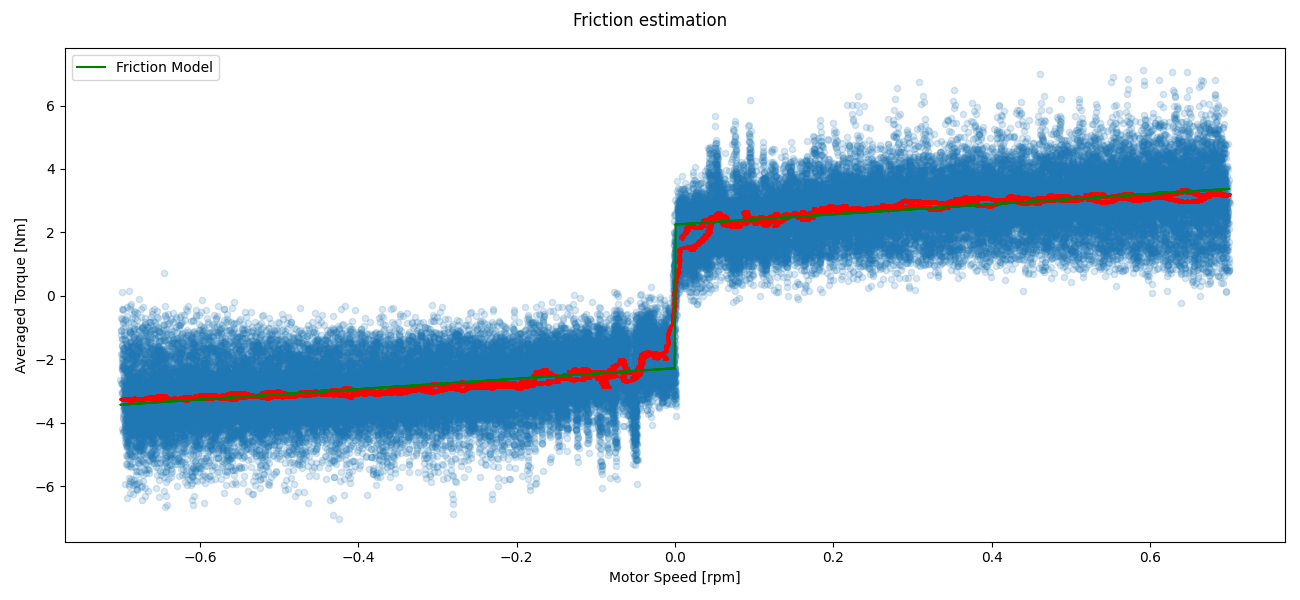

In [ ]:

def estimate_friction(df):
    # split data in positive and negative velocity
    positive_vt = df[df['Motor Speed [rpm]'] > 0]
    negative_vt = df[df['Motor Speed [rpm]'] < 0]

    # fit linear model
    pos_viscous, pos_coulomb,  = np.polyfit(positive_vt['Motor Speed [rpm]'], positive_vt['Motor Torque [Nm]'], 1)
    neg_viscous, neg_coulomb,  = np.polyfit(negative_vt['Motor Speed [rpm]'], negative_vt['Motor Torque [Nm]'], 1)

    # average
    coulomb = (pos_coulomb - neg_coulomb) / 2
    viscous = (pos_viscous + neg_viscous) / 2
    print(f'coulomb: {coulomb:.5f}[Nm], ({pos_coulomb:.5f}, {neg_coulomb:.5f})')
    print(f'viscous: {viscous:.5f} [Nm/(rev/s)], ({pos_viscous:.5f}, {neg_viscous:.5f})')

    #create model lines for pos and neg seperately
    pos_model = positive_vt.copy()
    pos_model['Friction Model'] = pos_viscous * pos_model['Motor Speed [rpm]'] + pos_coulomb
    neg_model = negative_vt.copy()
    neg_model['Friction Model'] = neg_viscous * neg_model['Motor Speed [rpm]'] + neg_coulomb

    # combine the two models
    fric_model = pd.concat([neg_model, pos_model])

    return fric_model

def average_data(df, groupby):
    data = []
    grouped = df.groupby(groupby)

    for name, group in grouped:
        group = group.drop(groupby, axis=1)
        group.index = group.index - group.index[0]

        old_len = len(group)
        group = group.resample('0.1ms').mean()
        group = group.interpolate(method='time')
        print(f'group {name} resampled from {old_len} to {len(group)} samples')

        data.append(group.values)

        if len(data) > 100:
            break

    data = data[5:100]

    # get consistent length
    min_len = min([len(d) for d in data])
    data = [d[:min_len] for d in data]
    print(f'setting everything to {min_len} samples')

    # average data using numpy
    data_mean = np.mean(np.array(data), axis=0)

    new_columns = df.columns.drop(groupby)
    mean_df = pd.DataFrame(data_mean, columns=new_columns)

    # smooth data
    mean_df = mean_df.rolling(window=100, center=True).mean()
    mean_df = mean_df.bfill().ffill()

    return mean_df


df = tests_split_pccf.speed_ramps['initial']

# plot measurements
fig, axs = plt.subplots(1, 1, figsize=(13, 6))
axs = [axs]

df.plot(x='Motor Speed [rpm]', y='Motor Torque [Nm]', kind='scatter', alpha=0.17, ax=axs[0])
df.plot(x='Motor Speed [rpm]', y='Averaged Torque [Nm]', kind='scatter', color='red', ax=axs[0], s=1)

# plot estimated friction
print(f'Estimated friction for :')
fric_model = estimate_friction(df)
fric_model.plot(x='Motor Speed [rpm]', y='Friction Model', color='green', ax=axs[0])

# # plot torque over position 
# df['REVOLUTIONS'] = np.floor(df['POSITION'])
# df['POSITION'] = df['POSITION'] - df['REVOLUTIONS']

# n_plots = int(df['REVOLUTIONS'].max())
# colors = plt.cm.viridis(np.linspace(0, 1, n_plots))
# for i in range(0, n_plots):
#     rev = df[(df['REVOLUTIONS'] == i) & (df['Motor Speed [rpm]'] > 0)]
#     rev.plot(x='POSITION', y='Motor Torque [Nm]', ax=axs[1], color=colors[i], alpha=0.4, legend=False)

# avg_fric = average_data(df, 'REVOLUTIONS')
# avg_fric.plot(x='POSITION', y='Motor Torque [Nm]', color='red', ax=axs[1])

fig.suptitle('Friction estimation')
fig.tight_layout()
    
plt.show()

averaging of multiple locking positions example with intermediate results

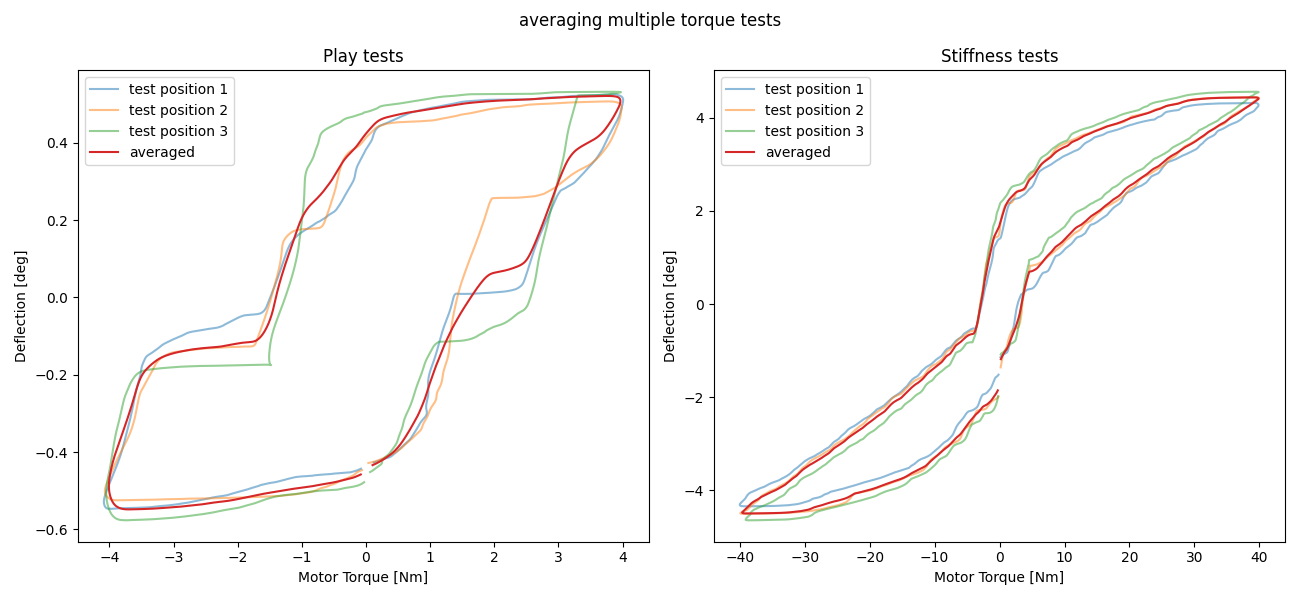

In [ ]:
selected_test = tests_conic_pccf.torque_ramps['preload increase 1']

fig, axs = plt.subplots(1, 2, figsize=(13, 6))
for name, (play_test, stiffness_test) in selected_test.items():
    if name == 'combined':
        a = 1
        label = 'averaged'
    else:
        a = 0.5
        label = f'test position {name+1}'
    play_test.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[0], label=label, alpha=a)
    stiffness_test.plot(x='Motor Torque [Nm]', y='Deflection [deg]', kind='line', ax=axs[1], label=label, alpha=a)

fig.suptitle('averaging multiple torque tests')
axs[0].set_title('Play tests')
axs[1].set_title('Stiffness tests')
axs[0].set_ylabel('Deflection [deg]')
axs[1].set_ylabel('Deflection [deg]')

fig.tight_layout()
plt.show()